In [1]:
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install --no-deps torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html -i https://mirrors.aliyun.com/pypi/simple/
# !pip install --no-deps torchaudio==0.10.0 -i https://mirrors.aliyun.com/pypi/simple/
# !pip install paddlepaddle-gpu==2.4.2 -i https://mirrors.aliyun.com/pypi/simple/

In [1]:
import warnings
warnings.filterwarnings("ignore")

import argparse
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio

from tqdm import tqdm

import sys
sys.path.append("../")
from pyfiles.dataset import PretrainingMelDataset
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import joblib
import glob

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
# Dataset Variables
dataset_dir = "/mntcephfs/lee_dataset/tts/LibriTTS_R/"
# feat_base_dir = "/mntcephfs/lab_data/shoinoue/Dataset/LibriTTS_R/features/"
feat_base_dir = "/mntcephfs/data/audiow/shoinoue/Dataset/LibriTTS_R/features/"

scaler_filename = f"ckpts/scalers/LibriTTS-R_16000.save"
# scaler_filename = f"ckpts/scalers/LibriTTS-R.save" # if model size is smaller
scaler = joblib.load(scaler_filename)

In [8]:
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/encoder_fine-tuning_nocondition_melmel_small/checkpoint-400000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/encoder_fine-tuning_nocondition_melmel_fromhubert_smaller/checkpoint-50000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/encoder_fine-tuning_nocondition_melmel_fromhubert_small/checkpoint-200000steps.pkl"

# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/encoder_fine-tuning_nocondition_melmel_fromhubert_norepeating_smaller/checkpoint-100000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/encoder_fine-tuning_nocondition_melmel_fromhubert_norepeating_small/checkpoint-50000steps.pkl"
# checkpoint_path = "/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/encoder_fine-tuning_nocondition_melmel_fromhubert_norepeating/checkpoint-100000steps.pkl"

if "smaller" in checkpoint_path:
    size = "smaller"
elif "small" in checkpoint_path:
    size = "small"
else:
    size = ""

args = {}
args["rank"] = 0
args["checkpoint"] = checkpoint_path
args["outdir"] = os.path.dirname(args["checkpoint"]) + "/"
args["config_path"] = f"./../egs/l2-arctic/cascade/conf/{size}m2mvtn.melmel.yaml"
args["init_checkpoint"] = ""
args["resume"] = ""
args["distributed"] = False
args = Dict2Obj(args)

# load main config
with open(args.config_path) as f:
    config = yaml.load(f, Loader=yaml.Loader)
config.update(vars(args))

# Customization
if "addition" in checkpoint_path:
    config["model_params"]["conditiontype"] = "add"
elif "concatenation" in checkpoint_path:
    config["model_params"]["conditiontype"] = "concat"
elif "nocondition" in checkpoint_path:
    config["model_params"]["conditiontype"] = "nocondition"

In [9]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(args.rank)
    
### Dataset Preparation ###
dataset = PretrainingMelDataset(feat_base_dir, dataset_dir, [scaler,scaler], "test", input_output_type=["mel", "mel"], defiling_ratio=[0,0,1])
# Get only the short audio
target_length = 150
lengths = []
for i in tqdm(range(len(dataset))):
    length = dataset[i]["src_feat"].shape[0]
    lengths += [length]
bool_list = np.array(lengths)<target_length
dataset.ifiles = list(np.array(dataset.ifiles)[bool_list])
dataset.files = list(np.array(dataset.files)[bool_list])

### Model Preparation ###
model_class = getattr(seq2seq_vc.models, config["model_type"])
model = model_class(**config["model_params"])
model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
model = model.eval().to(device)
    
### Vocoder Preparation ###
data_dir = "/mntcephfs/lab_data/shoinoue/"
# fs = 24000
fs = 16000

if fs==24000:
    config_path = f"{data_dir}Models/trained_models/vocos/24k/config.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/24k/pytorch_model.bin"
elif fs==16000:
    config_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/config16k.yaml"
    model_path = f"{data_dir}Models/trained_models/vocos/vocos16k_noncausal_tealab/vocos16k_noncausal_last.ckpt"
vocoder = get_vocos(config_path, model_path, fs)

100%|██████████| 4837/4837 [00:09<00:00, 511.76it/s]


In [10]:
with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
    for idx, batch in enumerate(pbar, 1):
        start_time = time.time()
        utt_id = os.path.basename(dataset.files[idx-1]).split(".")[0]
        x = batch["src_feat"]
        x = torch.tensor(x, dtype=torch.float).to(device)
        xembs = torch.tensor(batch["src_condition"].reshape(1, -1), dtype=torch.float).to(device)
        yembs = torch.tensor(batch["trg_condition"].reshape(1, -1), dtype=torch.float).to(device)
        outs, probs, att_ws = model.inference(
            x, config["inference"], xembs, yembs, spemb=None
        )

        # plot figures
        plot_generated_and_ref_2d(
            outs.cpu().numpy(),
            config["outdir"] + f"/outs/{utt_id}.png",
            origin="lower",
        )
        
        plot_1d(
            probs.cpu().numpy(),
            config["outdir"] + f"/probs/{utt_id}_prob.png",
        )
        plot_attention(
            att_ws.cpu().numpy(),
            config["outdir"] + f"/att_ws/{utt_id}_att_ws.png",
        )
        
        ### Waveform ###
        if not os.path.exists(os.path.join(config["outdir"], "wav")):
            os.makedirs(os.path.join(config["outdir"], "wav"), exist_ok=True)
        denormalized_mel = scaler.inverse_transform(cuda2numpy(outs))
        y = vocoder.decode(torch.tensor(denormalized_mel.T).unsqueeze(0))
        sf.write(
            os.path.join(config["outdir"], "wav", f"{utt_id}.wav"),
            y.cpu().numpy()[0],
            fs,
            "PCM_16",
        )
        
        ### Mel ###
        if not os.path.exists(os.path.join(config["outdir"], "mel")):
            os.makedirs(os.path.join(config["outdir"], "mel"), exist_ok=True)
            
        denormalized_input_mel = scaler.inverse_transform(x.cpu().numpy())
        np.save(os.path.join(config["outdir"], "mel", f"output_{utt_id}.npy"), denormalized_mel)
        np.save(os.path.join(config["outdir"], "mel", f"input_{utt_id}.npy"), denormalized_input_mel)
        np.save(os.path.join(config["outdir"], "probs", f"probs_{utt_id}.npy"), probs.cpu().numpy())
        np.save(os.path.join(config["outdir"], "att_ws", f"attws_{utt_id}.npy"), att_ws.cpu().numpy())
        if idx>2:
            break

[decode]:   0%|          | 2/1239 [00:30<5:14:23, 15.25s/it]


# Check the result

source


ground truth


predicted


<AxesSubplot: title={'center': 'attention weight'}>

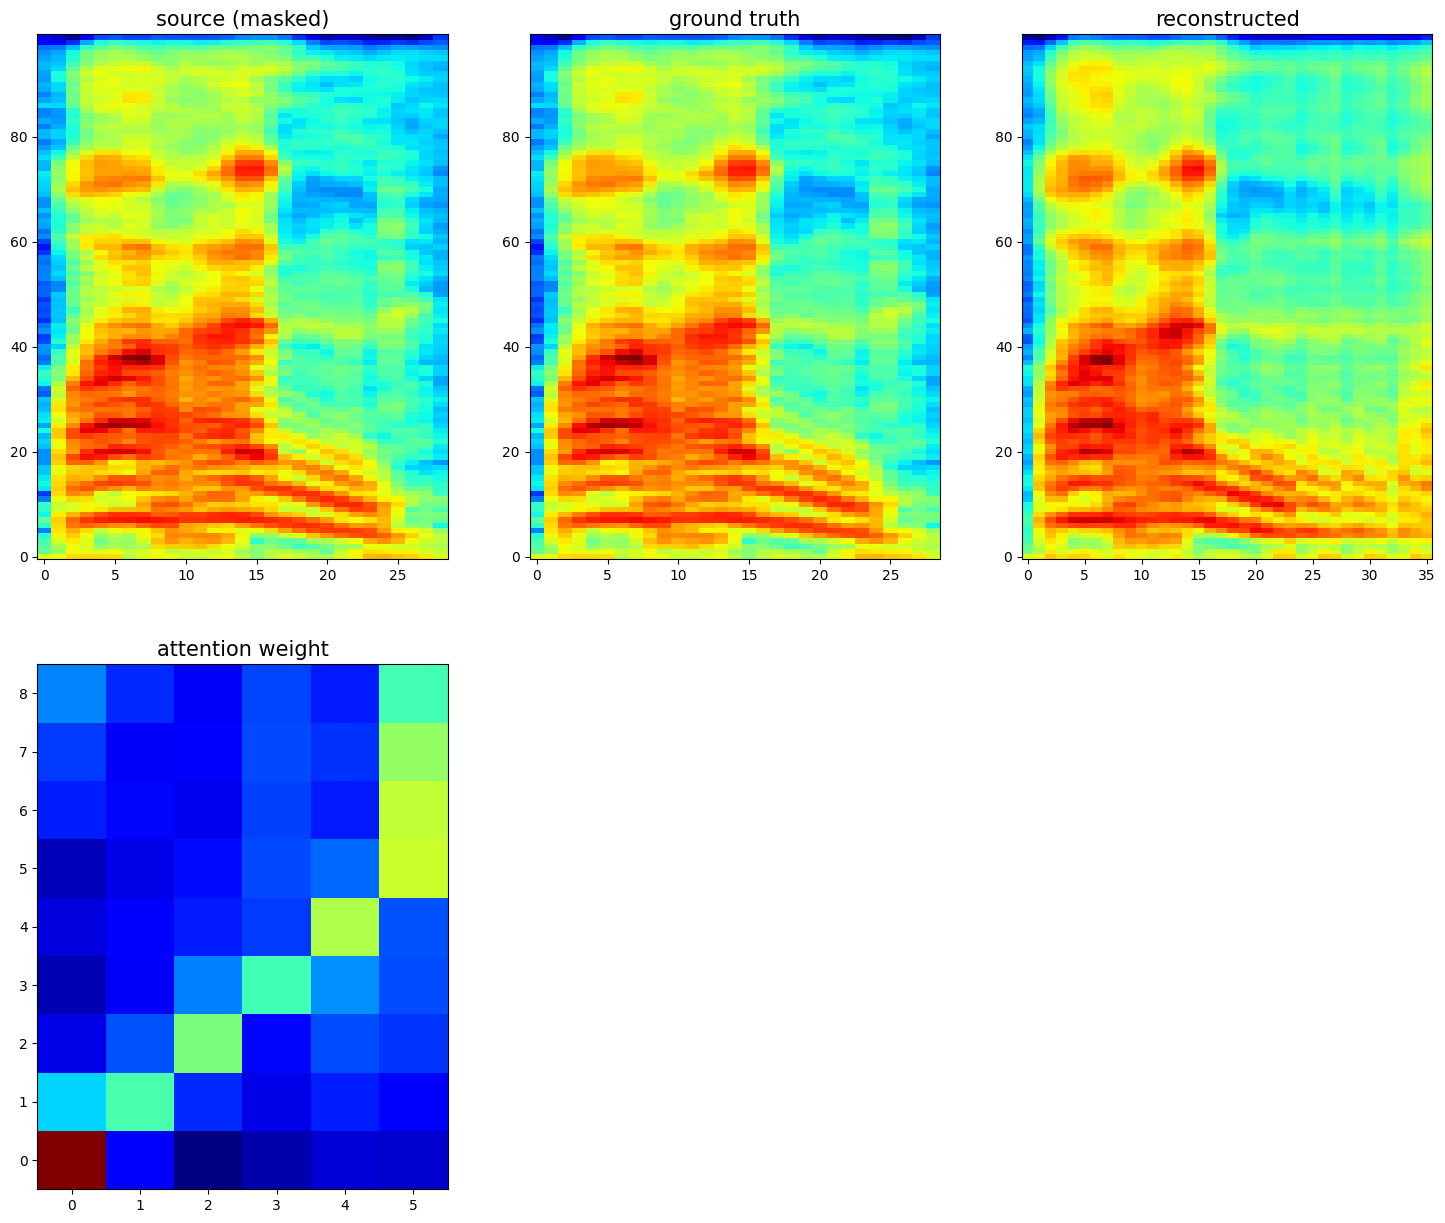

In [13]:
utt_id = dataset.files[0]
utt_basename = os.path.basename(utt_id)[:-4]
data = dataset[dataset.files.index(utt_id)]

imelpath = os.path.join(config["outdir"], "mel", f"input_{utt_basename}.npy")
omelpath = os.path.join(config["outdir"], "mel", f"output_{utt_basename}.npy")
wavpath = os.path.join(config["outdir"], "wav", f"{utt_basename}.wav")
predmel = np.load(omelpath)
predwav, sr = torchaudio.load(wavpath)
gtmel = data["trg_feat"]
gtmel = scaler.inverse_transform(gtmel)
gtwav = vocoder.decode(torch.tensor(gtmel.T).unsqueeze(0))
sourcemel = np.load(imelpath)
sourcewav = vocoder.decode(torch.tensor(sourcemel.T).unsqueeze(0))

%matplotlib inline  
fig = plt.figure(figsize=(18, 15))
print("source")
play_audio(sourcewav, fs)
print("ground truth")
play_audio(gtwav, fs)
print("predicted")
play_audio(predwav, sr)

plot_spectrogram(sourcemel.T, fig, (2,3,1), title="source (masked)")
plot_spectrogram(gtmel.T, fig, (2,3,2), title="ground truth")
plot_spectrogram(predmel.T, fig, (2,3,3), title="reconstructed")

probs = np.load(os.path.join(config["outdir"], "probs", f"probs_{utt_basename}.npy"))
attws = np.load(os.path.join(config["outdir"], "att_ws", f"attws_{utt_basename}.npy"))
att = np.array([attws[i][j] for i in range(attws.shape[0]) for j in range(attws.shape[1])]).mean(0)
plot_spectrogram(att, fig, (2,3,4), title="attention weight")